# <span style="color:Aquamarine">XpandIT Challenge</span>

**Main goal:** <br>
    The client has 100€ to invest in a single company each week, your task is to build a system that predicts what will be the best company to invest each week.
    The stock will be bought at the start of the week and will be sold at the end of it.

### Imports

In [1]:
import os
import math
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
#from tensorflow.keras import Sequential
#from keras.layers import Dense, LSTM, InputLayer
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


### Loading Data

In [2]:
#data supplied by the compamy
dir_location = os.path.abspath(os.path.dirname('.'))
data_location =  os.path.join(dir_location, "dow_jones_index.csv")

In [3]:
############# maybe optimizing the params on read
df = pd.read_csv(data_location)
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


## PreProcessing

### Data quality

In [4]:
df.dtypes

quarter                                 int64
stock                                  object
date                                   object
open                                   object
high                                   object
low                                    object
close                                  object
volume                                  int64
percent_change_price                  float64
percent_change_volume_over_last_wk    float64
previous_weeks_volume                 float64
next_weeks_open                        object
next_weeks_close                       object
percent_change_next_weeks_price       float64
days_to_next_dividend                   int64
percent_return_next_dividend          float64
dtype: object

In [5]:
#removing $
for col in df.columns[3:7]:
    df[col] = df[col].str.replace('$','')    

In [6]:
#removing $
for col in df.columns[11:13]:
    df[col] = df[col].str.replace('$','')   

In [7]:
#changing type

for col in df:
    #print(df[col])
    if df[col].dtypes == object and col != 'stock' and col != 'date': 
        df[col] = pd.to_numeric(df[col], errors='coerce') # 

In [8]:
#change object date to type date
df['date'] = pd.to_datetime(df['date'])

In [9]:
####Split_train_test done acordingly with literature
df_train = df.loc[df['quarter'] == 1]
df_test = df.loc[df['quarter'] == 2]
#Jan to March 2011
#print('Total nbr of lines in the train split is: ',len(df_train))
#April to June 2011
#print('Total nbr of lines in the test split is: ',len(df_test))

**Stock data** is by definition **Time series data**, i.e, set of observations, or data points, which are taken in a specified time, in this case, 2011. In order to figure out, which kind of transformations/algorithms we can apply, let's study the data. 

### EDA

In [10]:
print('Number of total stocks', df['stock'].nunique())

Number of total stocks 30


In [11]:
df_eda = df_train[['date','open','high', 'low', 'close', 'volume']]
df_eda = df_eda.set_index('date')

In [12]:
#generating dif df for each stock for visualization purposes
chunk_size = int(len(df_eda) / 30) #total nbr of diferent stocks
df_list = [] 
for start in range(0, len(df_eda), chunk_size):
    df_subset = df_eda.iloc[start:start + chunk_size]
    df_list.append(df_subset)

In [13]:
#1 df per stock
df_AA, df_AXP, df_BA, df_BACs = df_list[0], df_list[1], df_list[2], df_list[3]

In [14]:
df_AA.head()

,open,high,low,close,volume
date,,,,,
2011-01-07,15.82,16.72,15.78,16.42,239655616
2011-01-14,16.71,16.71,15.64,15.97,242963398
2011-01-21,16.19,16.38,15.60,15.79,138428495
2011-01-28,15.87,16.63,15.82,16.13,151379173
2011-02-04,16.18,17.39,16.18,17.14,154387761


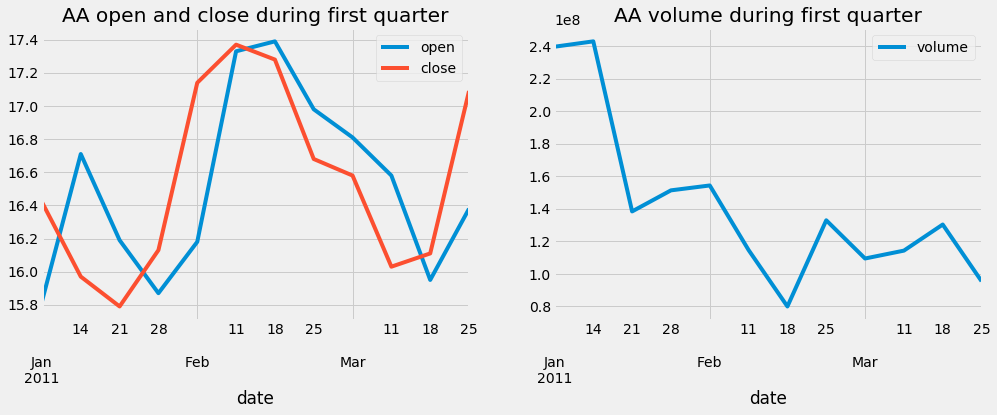

In [15]:
#tabela invisivel
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#open, close plot
df_AA[['open', 'close']].plot(ax = axes[0])
axes[0].set_title('AA open and close during first quarter')

#volume plot
df_AA[['volume']].plot(ax = axes[1])
axes[1].set_title('AA volume during first quarter')
plt.show()

############# check escala no volume, aquilo nem parecem milhoes

#### Studying Stationality

In [16]:
### Constant Mean
################## df_AA, in case it works apply to original df
df_AA.rolling(7).mean().head(10)

,open,high,low,close,volume
date,,,,,
2011-01-07,NaN,NaN,NaN,NaN,NaN
2011-01-14,NaN,NaN,NaN,NaN,NaN
2011-01-21,NaN,NaN,NaN,NaN,NaN
2011-01-28,NaN,NaN,NaN,NaN,NaN
2011-02-04,NaN,NaN,NaN,NaN,NaN
2011-02-11,NaN,NaN,NaN,NaN,NaN
2011-02-18,16.498571,16.998571,16.181429,16.585714,1.602185e+08
2011-02-25,16.664286,17.060000,16.207143,16.622857,1.449794e+08
2011-03-04,16.678571,17.092857,16.277143,16.710000,1.259122e+08


Pretty much constant mean!

In [17]:
df_AA.rolling(7).std().head(10)

,open,high,low,close,volume
date,,,,,
2011-01-07,NaN,NaN,NaN,NaN,NaN
2011-01-14,NaN,NaN,NaN,NaN,NaN
2011-01-21,NaN,NaN,NaN,NaN,NaN
2011-01-28,NaN,NaN,NaN,NaN,NaN
2011-02-04,NaN,NaN,NaN,NaN,NaN
2011-02-11,NaN,NaN,NaN,NaN,NaN
2011-02-18,0.656110,0.504758,0.677211,0.664802,6.089309e+07
2011-02-25,0.600274,0.491189,0.662689,0.661254,5.008956e+07
2011-03-04,0.602728,0.471159,0.617109,0.598052,2.635430e+07


<ipython-input-18-8f2c1af09c3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AA['close: 7 Days mean'] = df_AA.rolling(7).mean()['close']
<ipython-input-18-8f2c1af09c3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_AA['close: 7 Days std'] = df_AA.rolling(7).std()['close']


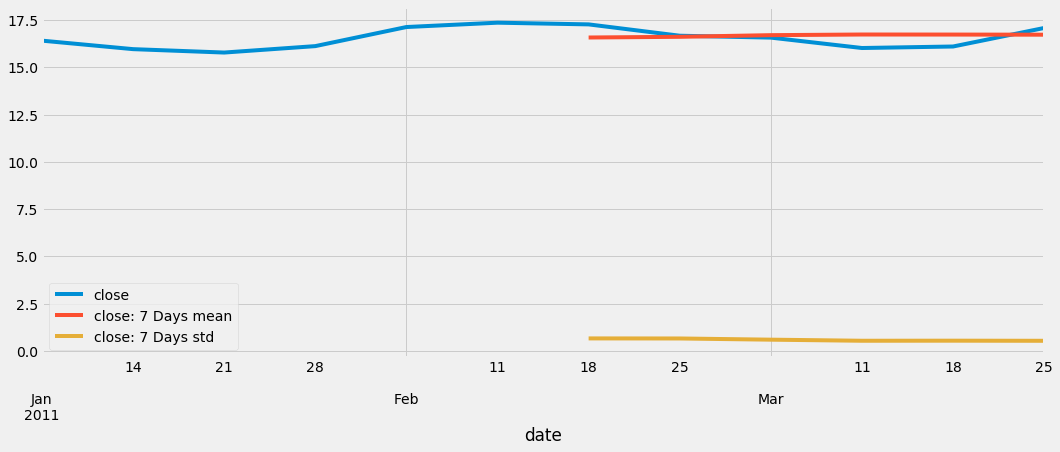

In [18]:
#Plotting new stats 
df_AA['close: 7 Days mean'] = df_AA.rolling(7).mean()['close']
df_AA['close: 7 Days std'] = df_AA.rolling(7).std()['close']
df_AA[['close','close: 7 Days mean', 'close: 7 Days std']].plot(figsize=(16,6))
plt.show()

Pretty much constant variance!
Checking our plot, we can see that also, there's no seasonality, that being said, **we verify all the three assumptions of sationarity**.

In [19]:
#training dataset, only with AA['close'] becauseon average the values are very similar
#df_AA[['close', 'volume']]
data = df_AA['close']
dataset = data.values

In [20]:
training_data_len = len(data)
print('Len training_data_len', training_data_len)

Len training_data_len 12


In [21]:
dataset = dataset.reshape(-1,1)
#print(dataset)

In [22]:
#################################################
#Good Practice: scaling the data before LSTM model
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
#print(scaled_data)

In [23]:
# creating the scaled training dataset
train_data = scaled_data
#split the data into x_train and y_train data set
x_train = []
y_train = []


for i in range(4, len(train_data)):
    x_train.append(train_data[i-4:i,0])
    y_train.append(train_data[i,0])
    #if i <= 5:
    #   print('este é o x_train', x_train)
    #   print('este é o y_train', y_train)

In [24]:
#convert the x_train and Y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
#LSTM model needs 3D arrays, so we need to reshape data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) #samples/rows, timesteps/cols (?????), features/close
#24total nbr os data dor AA, 12 total number os train data, 1 closing col

In [25]:
x_train.shape

(8, 4, 1)

In [26]:
#Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(x_train.shape[1],1))) # return_sequences to use more layers, input_shape = first layer
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [28]:
#compiling the model
model.compile(optimizer='adam', loss='mean_squared_error') #optimizer to improve over the loss function

In [29]:
#train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
8/8 [==============================] - 1s 125ms/step - loss: 0.3824


In [27]:
#df_AA['Close:5 Day Mean'] = df_AA.rolling(window=5).mean()
#df_AA[['close','Close: 5 Day Mean']].plot(figsize=(16,6))
#plt.title('Closing Price history and 5 Days Mean')
#plt.show()